# New York City Taxi Trip Duration
- goal is to predict duration of trip
- inspired by GrandMaster Mr. Beluga's [notebook](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [16, 10]

train = pd.read_csv('../input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.zip')
sample_submission = pd.read_csv('../input/nyc-taxi-trip-duration/sample_submission.zip')

### EDA

In [2]:
print('Number of samples:', train.shape[0])
print('Number of numerical features:', train.select_dtypes(include=['int64','float64']).shape[1])
print('Number of categorical featrues:', train.select_dtypes(include='object').shape[1])
train.head(3)

Number of samples: 1458644
Number of numerical features: 7
Number of categorical featrues: 4


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [3]:
print('There are unique values for id:',train.id.nunique()==train.shape[0])
print('There is no missing values:',train.count().min() == train.shape[0])

There are unique values for id: True
There is no missing values: True


In [4]:
first=set(train.columns)
second=set(test.columns)
print('Missing columns from test set:', first-second)

Missing columns from test set: {'dropoff_datetime', 'trip_duration'}


In [5]:
# Chaging string value into integer

In [6]:
train['store_and_fwd_flag']=[0 if x=='N' else 1 for x in train['store_and_fwd_flag']]
test['store_and_fwd_flag']=[0 if x=='N' else 1 for x in test['store_and_fwd_flag']]

# Changing to datetime values
- Changing to pandas datetime
- adding a minute, hour, day, week hour and month column to train and test dataset

In [7]:
# Changing to datetime
train['pickup_datetime']=pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime']=pd.to_datetime(train.dropoff_datetime)
test['pickup_datetime']=pd.to_datetime(test.pickup_datetime)

#adding minute column
train['minute']=train.pickup_datetime.dt.minute
test['minute']=train.pickup_datetime.dt.minute

# adding hour column
train['hour']=train.pickup_datetime.dt.hour
test['hour']=test.pickup_datetime.dt.hour

# adding day column
train['day']=train.pickup_datetime.dt.weekday
test['day']=train.pickup_datetime.dt.weekday

# adding week hour column
train['week_hour']=train['day']*24+train['hour']
test['week_hour']=test['day']*24+test['hour']

# adding month column
train['month']=train.pickup_datetime.dt.month
test['month']=train.pickup_datetime.dt.month


No need to look for yearly cyclical patterns because the sample are from a 5 month period.

In [8]:
print('Time frame of the data set:', train.month.max()-train.month.min(), 'months')

Time frame of the data set: 5 months


# Distribution of time values
- Day of the week is nearly uniformally distributed
- Hour of day has a distinct patter
- More observations are made in the last month

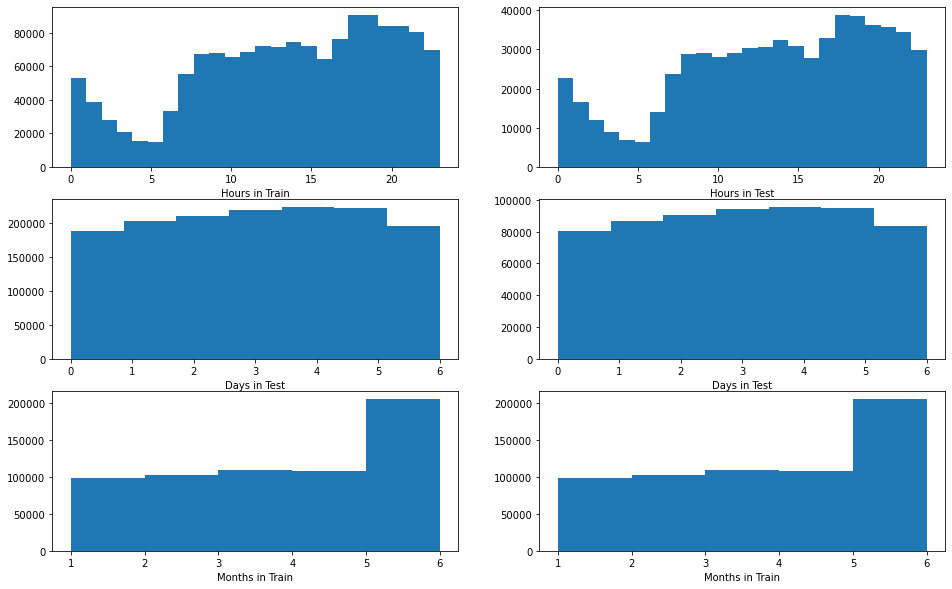

In [9]:
fig, ax =plt.subplots(3,2)

# hour
ax[0,0].hist(train.hour, bins=24)                 
ax[0,0].set_xlabel('Hours in Train')
ax[0,1].hist(test.hour, bins=24)
ax[0,1].set_xlabel('Hours in Test')

# day
ax[1,0].hist(train.day, bins=7)                   
ax[1,0].set_xlabel('Days in Test')
ax[1,1].hist(test.day, bins=7)
ax[1,1].set_xlabel('Days in Test')

# month
ax[2,0].hist(test.month, bins=5)                
ax[2,0].set_xlabel('Months in Train')
ax[2,1].hist(test.month, bins=5)
ax[2,1].set_xlabel('Months in Train')
plt.show()

# Distribution of the target vairable
- Raw data is very skewed due to some very long trips. The variable resembles normal after a log transformation. 

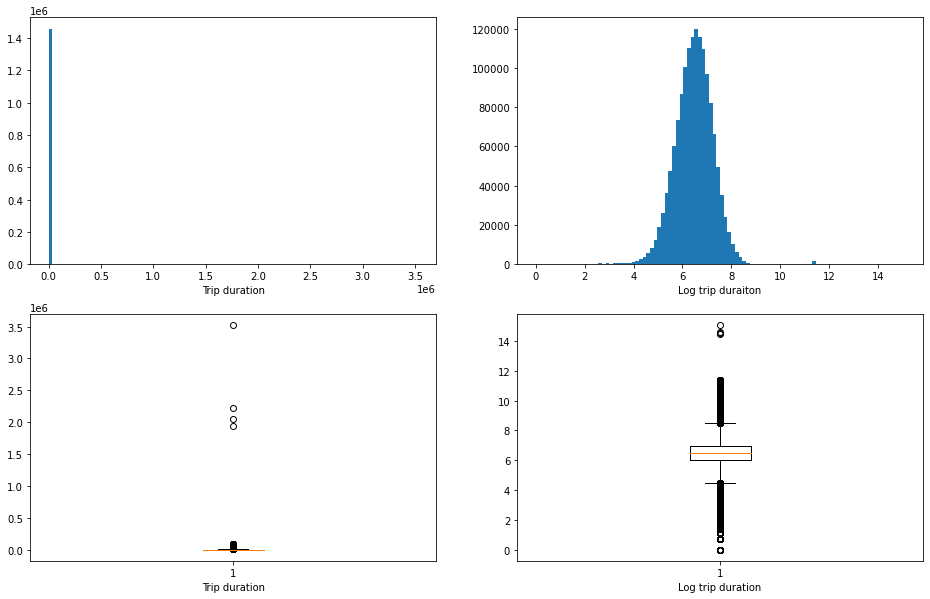

In [10]:
train['log_duration']=np.log(train['trip_duration'])
fig, ax = plt.subplots(2,2)
ax[0,0].hist(train['trip_duration'],bins=100)
ax[0,0].set_xlabel('Trip duration')
ax[0,1].hist(train['log_duration'],bins=100)
ax[0,1].set_xlabel('Log trip duraiton')
ax[1,0].boxplot(train['trip_duration'])
ax[1,0].set_xlabel('Trip duration')
ax[1,1].boxplot(train['log_duration'])
ax[1,1].set_xlabel('Log trip duration')
plt.show()

# Feature Extraction
- inspired by Nir Malbin's [notebook](https://www.kaggle.com/donniedarko/darktaxi-tripdurationprediction-lb-0-385)
- This will transform the coordinates. The idea is that our trees will have more features to work with. It's proved to a successful technique in other kernels 

In [11]:
# stacking all the coordinates from the training and test set
coords=np.vstack((train[['pickup_latitude','pickup_longitude']], train[['pickup_latitude','pickup_longitude']],
                 test[['pickup_latitude','pickup_longitude']], test[['pickup_latitude','pickup_longitude']]))

# Keeping coordinates that fall within one standard deviation
min_lat, min_lng = coords.mean(axis=0)-coords.std(axis=0)
max_lat, max_lng = coords.mean(axis=0)+coords.std(axis=0)
coords=coords[(coords[:,0]>min_lat) & (coords[:,0]<max_lat) & (coords[:,1] > min_lng) & (coords[:,1] < max_lng)]

# PCA transformation
pca=PCA().fit(coords)
coords_pca=pca.transform(coords)

- visualing the new features compared to the old

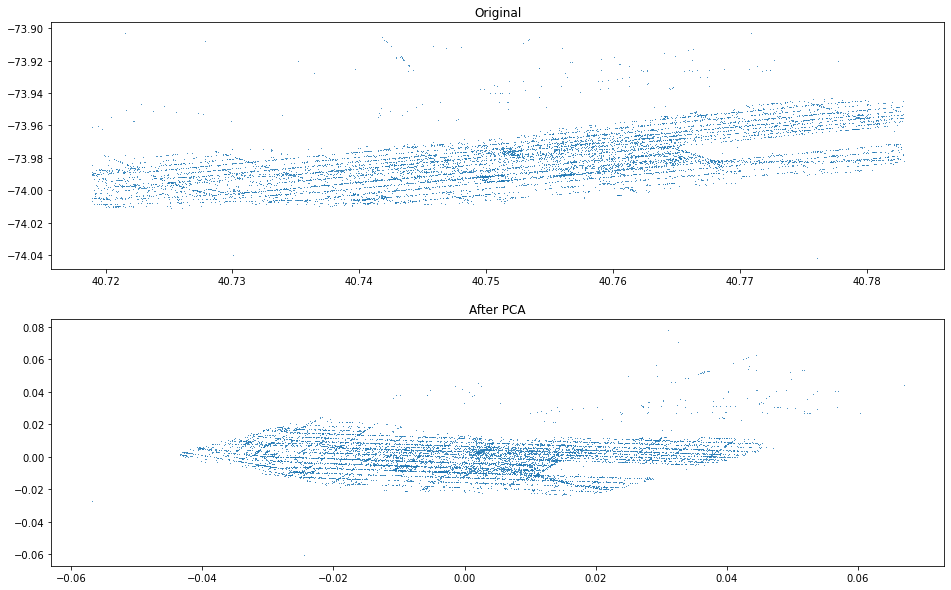

In [12]:
fig, ax = plt.subplots(2, 1)
sample_ind = np.random.permutation(len(coords))[:10000]
ax[0].scatter(coords[sample_ind,0], coords[sample_ind,1], s=1, lw=0)
ax[0].set_title('Original')
ax[1].scatter(coords_pca[sample_ind,0], coords_pca[sample_ind,1], s=1, lw=0)
ax[1].set_title('After PCA')
plt.show()

- adding new features to training and test sets

In [13]:
# train pickup
train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]  
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]

# train dropoff
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]    
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]

# train pickup
test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]   
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]

# train dropoff
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]    
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]


# Distance and direction variables
- Manhattan method with PCA values = abs(dropoff-pickup)
- the Haversine formula is an accurate measurement on popular to calcuate distances spherical surfaces. \
$$distance = 2r*arcsin\sqrt{sin^{2}\frac{lat2-lat1}{2}+cos(lat1)cos(lat2)sin^{2}\frac{lng2-lng1}{2}}$$ <br> where r is the radius of the earth at New York
- we can also find the direction with arctan2(x,y) <br> where x = sin(lng2-lng1)*cos(lat2) and y = cos(lat1)sin(lat2)-sin(lat1)cos(lat2)cos(lng2-lng1)

In [14]:
# function to creat harvsin distance
def harvsin(lat1,lng1,lat2,lng2):
    radius=6369
    lat1,lng1,lat2,lng2=map(np.radians,(lat1,lng1,lat2,lng2))
    lat=lat2-lat1
    lng=lng2-lng1
    inside=(np.sin(lat*0.5)**2)+np.cos(lat1)*np.cos(lat2)*(np.sin(lng*0.5)**2)
    return 2*radius*np.arcsin(np.sqrt(inside))

# function to determine distance
def bearing(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# adding Manhattan distance, harvsine distance, and direction to training set
train['pca_manhattan']=(train['dropoff_pca0']-train['pickup_pca0']).abs()+(train['dropoff_pca1']-train['pickup_pca1']).abs()
train['harvsin']=harvsin(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'])
test['direction']=bearing(train['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])

# adding Manhattan distance, harvsine distance, and direction to test set 
test['pca_manhattan']=(test['dropoff_pca0']-test['pickup_pca0']).abs()+(test['dropoff_pca1']-test['pickup_pca1']).abs()
test['harvsin']=harvsin(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])
test['direction']=bearing(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])

# Speed

<function matplotlib.pyplot.show(close=None, block=None)>

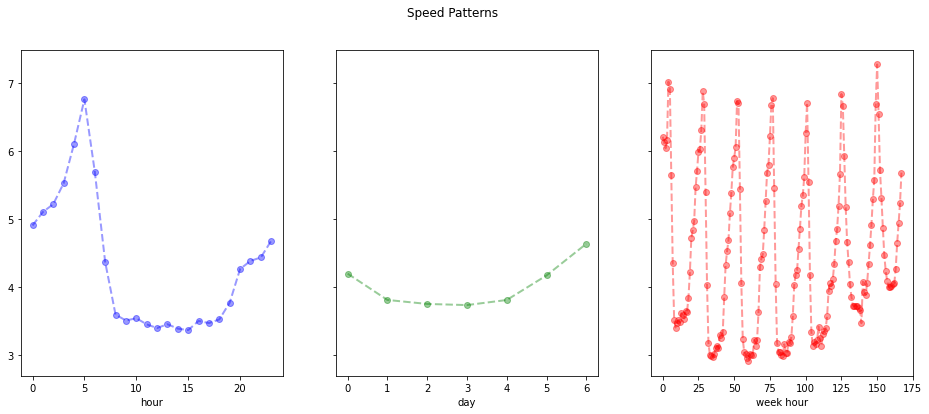

In [15]:
train['harvsin_speed']=1000*train['harvsin']/train['trip_duration']
train['manhattan_speed']=1000*train['pca_manhattan']/train['trip_duration']

fig, ax = plt.subplots(1,3,sharey=True, figsize=(16,6))
ax[0].plot(train.groupby('hour').mean()['harvsin_speed'],'bo--',lw=2,alpha=.4)
ax[0].set_xlabel('hour')
ax[1].plot(train.groupby('day').mean()['harvsin_speed'],'go--',lw=2,alpha=.4)
ax[1].set_xlabel('day')
ax[2].plot(train.groupby('week_hour').mean()['harvsin_speed'],'ro--',lw=2,alpha=.4)
ax[2].set_xlabel('week hour')
fig.suptitle('Speed Patterns')
plt.show

# Clustering by pickup and dropoff
- using the previous trimmed down coordinates to make cluster and traffic count into and out of clusters

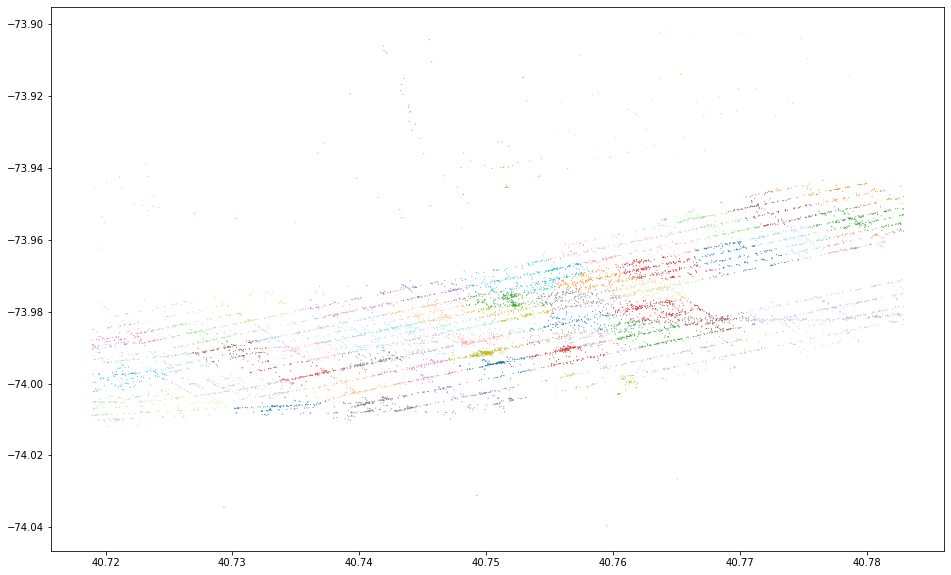

In [16]:
kmeans = MiniBatchKMeans(n_clusters=8**2, batch_size=32**3).fit(coords)
sample_ind=np.random.permutation(len(coords))[:10000]
plt.scatter(coords[sample_ind,0],coords[sample_ind,1],s=1,lw=0,c=kmeans.predict(coords[sample_ind]), cmap='tab20')

In [17]:
train['pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train['dropoff_cluster']=kmeans.predict(train[['dropoff_latitude','dropoff_latitude']])

test['pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test['dropoff_cluster']=kmeans.predict(test[['dropoff_latitude','dropoff_latitude']])

In [18]:
# combining training and test in order to count movement in and out of clusters
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]

train['pickup_datetime_group'] = train['pickup_datetime'].dt.round('60min')
test['pickup_datetime_group'] = test['pickup_datetime'].dt.round('60min')

# count dropoff into clusters
df_dropoff_counts = df_all.set_index('pickup_datetime').groupby([pd.Grouper(freq='60min'), 'dropoff_cluster']).agg({'id': 'count'}) \
                   .reset_index().set_index('pickup_datetime').groupby('dropoff_cluster').rolling('240min').mean().drop('dropoff_cluster', axis=1) \
                   .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
                   .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

# count pickups from clusters
df_pickup_counts = df_all.set_index('pickup_datetime').groupby([pd.Grouper(freq='60min'), 'pickup_cluster']).agg({'id': 'count'}) \
                  .reset_index().set_index('pickup_datetime').groupby('pickup_cluster').rolling('240min').mean().drop('pickup_cluster', axis=1) \
                  .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
                  .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

# adding counts into training
train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(df_dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(df_pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

# adding counts into test
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(df_dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(df_pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

# Supplamentry [data](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm)
- someone went through the trouble to extract the fastest routs. 

In [19]:
fr1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

# Selecting features and correlation

In [20]:
exclude = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime','trip_duration','log_duration',
           'pickup_datetime_group','harvsin_speed','manhattan_speed']
features=[x for x in train.columns if x not in exclude]
y_train=np.log(train['trip_duration'])

<AxesSubplot:>

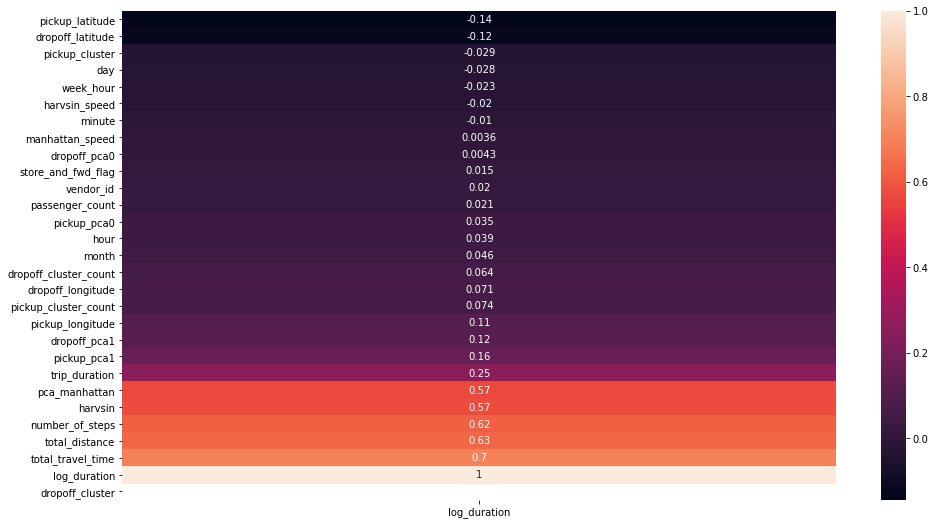

In [21]:
plt.figure(figsize=(16,9))
sns.heatmap(train.corr()[['log_duration']].sort_values('log_duration'), annot=True)

# Model with validation

In [22]:
# 20% is set aside as a validation set
X_train, X_val, y_train, y_val = train_test_split(train[features].values,y_train,test_size=.2)

# Data Matrix form to memory efficiency and training speed
train_matrix=xgb.DMatrix(X_train,label=y_train)
val_matrix=xgb.DMatrix(X_val,label=y_val)
test_matrix=xgb.DMatrix(test[features].values)

# using previously found parameters
xgb_pars=xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

watchlist = [(train_matrix, 'train'), (val_matrix, 'valid')]

model = xgb.train(xgb_pars, train_matrix, 100, watchlist, early_stopping_rounds=20,
                  maximize=False, verbose_eval=10)

[14:32:59] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:59] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.22620	valid-rmse:4.22858
[10]	train-rmse:0.42316	valid-rmse:0.43167
[20]	train-rmse:0.38662	valid-rmse:0.40085
[30]	train-rmse:0.37628	valid-rmse:0.39478
[40]	train-rmse:0.36974	valid-rmse:0.39212
[50]	train-rmse:0.36650	valid-rmse:0.39069
[60]	train-rmse:0.36262	valid-rmse:0.38921
[70]	train-rmse:0.35983	valid-rmse:0.38826
[80]	train-rmse:0.35786	valid-rmse:0.38795
[90]	train-rmse:0.35647	valid-rmse:0.38800
[99]	train-rmse:0.35448	valid-rmse:0.38780


In [23]:
y_test = model.predict(test_matrix)
test['trip_duration']=np.exp(y_test)
test[['id', 'trip_duration']].to_csv('ny_taxi_submission.csv.gz', index=False, compression='gzip')